<a href="https://colab.research.google.com/github/parmarsuraj99/numerai-guides/blob/master/better_evaluation/Numerai_evaluate_better.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Created by Suraj Parmar

- Numerai: [SurajP](https://numer.ai/surajp)

- Twitter: [@parmarsuraj99](https://twitter.com/parmarsuraj99)


Thanks to [@NJ](https://twitter.com/tasha_jade) and [@MikeP](https://twitter.com/EasyMikeP) for their guidence

# Don't just submit and wait. Evaluate!

A walkthrough to some evaluation metrics you can use for your models. 

This isn't ment to be a `Run All` notebook. I have tried to make this flexible and customizable so that you can adapt this to your workflow.

Hope this helps

## 1.0 Loading required libraries 📔 and dataset 🗄️🔽

In [1]:
!pip install numerapi
!pip install catboost;

In [2]:
import os
import gc
import csv
import sys
import glob
import time
from pathlib import Path
from multiprocessing import Pool

import numerapi

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression

In [3]:
napi = numerapi.NumerAPI(verbosity="info")
# download current dataset
napi.download_current_dataset(unzip=True)

current_ds = napi.get_current_round()
latest_round = os.path.join('numerai_dataset_'+str(current_ds))

2020-08-31 18:38:26,289 INFO numerapi.base_api: target file already exists


In [4]:
TOURNAMENT_NAME = "kazutsugi"
TARGET_NAME = f"target_{TOURNAMENT_NAME}"
PREDICTION_NAME = f"prediction_{TOURNAMENT_NAME}"

BENCHMARK = 0
BAND = 0.2

#-----------------------------------------------------

# Submissions are scored by spearman correlation
def score(df):
    # method="first" breaks ties based on order in array
    return np.corrcoef(
        df[TARGET_NAME],
        df[PREDICTION_NAME].rank(pct=True, method="first")
    )[0, 1]


# The payout function
def payout(scores):
    return ((scores - BENCHMARK) / BAND).clip(lower=-1, upper=1)


# Read the csv file into a pandas Dataframe
def read_csv(file_path):
    with open(file_path, 'r') as f:
        column_names = next(csv.reader(f))
        dtypes = {x: np.float16 for x in column_names if
                  x.startswith(('feature', 'target'))}
    return pd.read_csv(file_path, dtype=dtypes)

In [5]:
%%time
print("# Loading data...")
# The training data is used to train your model how to predict the targets.
training_data = read_csv(os.path.join(latest_round, "numerai_training_data.csv")).set_index("id")
# The tournament data is the data that Numerai uses to evaluate your model.
tournament_data = read_csv(os.path.join(latest_round, "numerai_tournament_data.csv")).set_index("id")

example_preds = read_csv(os.path.join(latest_round, "example_predictions_target_kazutsugi.csv")).set_index("id")

validation_data = tournament_data[tournament_data.data_type == "validation"]


# Loading data...
CPU times: user 1min 6s, sys: 3.42 s, total: 1min 9s
Wall time: 1min 37s


In [6]:
feature_names = [f for f in training_data.columns if f.startswith("feature")]
print(f"Loaded {len(feature_names)} features")

Loaded 310 features


In [7]:
TRAIN_EVAL_PREFIX = "train"
VAL_EVAL_PREFIX = "val"

## <center>Notebook Flow</center>
<p align="center">
  <img src="https://raw.githubusercontent.com/parmarsuraj99/numerai-guides/master/better_evaluation/images/notebook_flow.png" width=40%>
</p>

---

## <center>Some simple metrics to get started</center>
<p align="center">
  <img src="https://raw.githubusercontent.com/parmarsuraj99/numerai-guides/master/better_evaluation/images/simple_stats.png" width=70%">
</p>


## 2.1 Some added metrics for evaluation 🔬

This is just to get familiar with some simpler metrics. Functions with all the metrics are in the section 2.2

In [8]:
def spearmanr(target, pred):
    return np.corrcoef(
        target,
        pred.rank(pct=True, method="first")
    )[0, 1]

def get_basic_per_era_metrics(df:pd.DataFrame, 
                        isVal=None, 
                        fig_name="per_era_scores.png") -> pd.Series:
    """
    Some metrics related to per-era scores.
    Plots per-era mean correlation with `TARGET_NAME` column
    more metrics at: https://forum.numer.ai/t/more-metrics-for-ya/636

    Parameters
    ----------
    df_with_preds : pd.DataFrame
        Training or Toutnament DataFrame having predictions assigned
        at `PREDICTION_NAME` column.

    isVal: bool, optional, default:None
    
    fig_name: str, optional, default:per_era_scores.png

    Returns:
    ------
    pd.Series: Pandas Series having 
        (mean, std, %preds<0.5, and %preds<mean(preds), corr w/ example_preds)
    
    """

    prefix=None
    #Some checks for deciding between training and tournament data
    if isVal:
        df = df[df.data_type == "validation"]
        prefix=VAL_EVAL_PREFIX
        print("predicting on validation...")
    else:
        df = df
        prefix=TRAIN_EVAL_PREFIX
        print("predicting on train...")

    #-----------------------------------------------------
    scores = pd.Series(dtype=float)
    preds_ = df[PREDICTION_NAME]
    scores[f"{prefix}_mean"] = preds_.mean()
    scores[f"{prefix}_std_dev"] = preds_.std()

    #-----------------------------------------------------
    #Metric Calculations
    print("getting per era scores")
    era_scores = df.groupby("era").apply(
        lambda x: spearmanr(x[TARGET_NAME], x[PREDICTION_NAME]))
    
    era_scores.sort_index(inplace=True)
    era_scores.plot(kind="bar")
    print("performance over time")
    plt.savefig(f"{prefix}_{fig_name}")
    plt.show()

    #-----------------------------------------------------
    scores[f"{prefix}_mean correlation"] = np.mean(era_scores)
    scores[f"{prefix}_Std. Dev."] = np.std(era_scores)
    scores[f"{prefix}_sharpe"] = np.mean(era_scores)/np.std(era_scores)

    print(scores)
    del era_scores
    del preds_
    
    gc.collect()
    return scores


In [9]:
def get_all_metrics(model, 
                    feature_names:list=feature_names, 
                    fig_name="per_era_scores")->pd.Series:

    training_preds = model.predict(training_data[feature_names].values)
    training_data[PREDICTION_NAME] = np.array(training_preds).reshape(-1,1)

    tournament_preds = model.predict(tournament_data[feature_names].values)
    tournament_data[PREDICTION_NAME] = np.array(tournament_preds).reshape(-1,1)

    del training_preds
    del tournament_preds

    print("evaluating on training data...")
    tr_per_era_scores = get_basic_per_era_metrics(training_data, isVal=False, fig_name=fig_name)
    gc.collect()

    print("evaluating on validation data...")
    val_per_era_scores = get_basic_per_era_metrics(tournament_data, isVal=True, fig_name=fig_name)
    gc.collect()

    return pd.concat([
                      tr_per_era_scores, val_per_era_scores,
                      ])



### Creating some models 🤖

In [10]:
models = dict()

#Linear model
lin_reg = LinearRegression()
models["lin_reg"] = lin_reg

#Neural Net
nn_model = tf.keras.models.Sequential([
                                       tf.keras.layers.Input(shape=(310,)),
                                       tf.keras.layers.Dense(64, activation="relu"),
                                       tf.keras.layers.Dense(1, activation="sigmoid")
])
nn_model.compile(loss="mse", optimizer="adam", metrics = [tf.keras.metrics.RootMeanSquaredError()])

models["keras_mlp_simple"] = nn_model

del lin_reg
del nn_model

gc.collect()

0

### Training our models⚙️

In [11]:
for model_name in models:
    print(f"Fitting {model_name}...")

    if "keras" in model_name:
        models[model_name].fit(training_data[feature_names].values, training_data[TARGET_NAME].values, 
             batch_size=512, 
             epochs=40,
             validation_data=(validation_data[feature_names].values, validation_data[TARGET_NAME].values),
             )
    else:
        models[model_name].fit(training_data[feature_names].values, training_data[TARGET_NAME].values)

    gc.collect()

Fitting lin_reg...
Fitting keras_mlp_simple...
Epoch 1/40
981/981 [==============================] - 3s 3ms/step - loss: 0.1250 - root_mean_squared_error: 0.3535 - val_loss: 0.1252 - val_root_mean_squared_error: 0.3538
Epoch 2/40
981/981 [==============================] - 3s 3ms/step - loss: 0.1244 - root_mean_squared_error: 0.3528 - val_loss: 0.1249 - val_root_mean_squared_error: 0.3534
Epoch 3/40
981/981 [==============================] - 3s 3ms/step - loss: 0.1244 - root_mean_squared_error: 0.3526 - val_loss: 0.1249 - val_root_mean_squared_error: 0.3534
Epoch 4/40
981/981 [==============================] - 3s 3ms/step - loss: 0.1243 - root_mean_squared_error: 0.3526 - val_loss: 0.1249 - val_root_mean_squared_error: 0.3534
Epoch 5/40
981/981 [==============================] - 3s 3ms/step - loss: 0.1243 - root_mean_squared_error: 0.3525 - val_loss: 0.1253 - val_root_mean_squared_error: 0.3540
Epoch 6/40
981/981 [==============================] - 3s 3ms/step - loss: 0.1242 - root_mean_

### Evaluating models 🔬


----lin_reg----
evaluating on training data...
predicting on train...
getting per era scores
performance over time


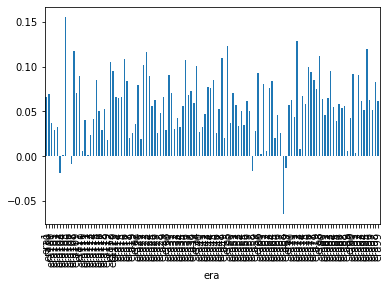

train_mean                0.499996
train_std_dev             0.019592
train_mean correlation    0.055647
train_Std. Dev.           0.035655
train_sharpe              1.560720
dtype: float64
evaluating on validation data...
predicting on validation...
getting per era scores
performance over time


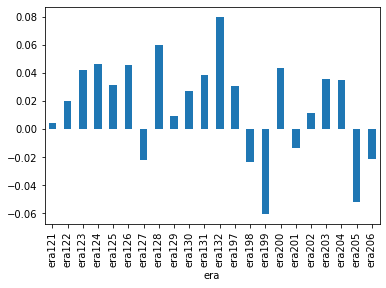

val_mean                0.500000
val_std_dev             0.019159
val_mean correlation    0.016740
val_Std. Dev.           0.035011
val_sharpe              0.478136
dtype: float64

----keras_mlp_simple----
evaluating on training data...
predicting on train...
getting per era scores
performance over time


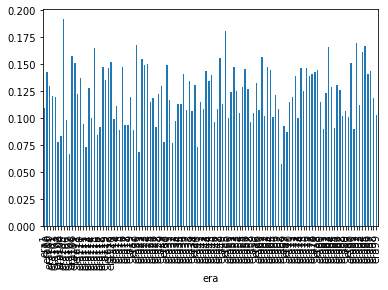

train_mean                0.502195
train_std_dev             0.044960
train_mean correlation    0.121219
train_Std. Dev.           0.026634
train_sharpe              4.551188
dtype: float64
evaluating on validation data...
predicting on validation...
getting per era scores
performance over time


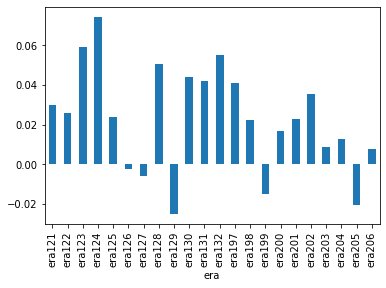

val_mean                0.503019
val_std_dev             0.046358
val_mean correlation    0.022915
val_Std. Dev.           0.025959
val_sharpe              0.882736
dtype: float64
CPU times: user 1min 19s, sys: 9.68 s, total: 1min 28s
Wall time: 1min 11s


In [12]:
%%time
all_model_metrics = dict()
for model_name in models:
    
    print(f"\n----{model_name}----")
    model_metrics = get_all_metrics(models[model_name], feature_names, fig_name = f"{model_name}.png")
    all_model_metrics[model_name] = model_metrics

    gc.collect()


In [13]:
metric_df = pd.DataFrame.from_dict(all_model_metrics)
metric_df

,lin_reg,keras_mlp_simple
train_mean,0.499996,0.502195
train_std_dev,0.019592,0.044960
train_mean correlation,0.055647,0.121219
train_Std. Dev.,0.035655,0.026634
train_sharpe,1.560720,4.551188
val_mean,0.500000,0.503019
val_std_dev,0.019159,0.046358
val_mean correlation,0.016740,0.022915
val_Std. Dev.,0.035011,0.025959
val_sharpe,0.478136,0.882736



- **`val_mean_correlation`** suggests how much your predictions are correlated to targets across `era`
- **`val_sharpe`** (mean/std) is for higher mean with lower std. dev.
- **`tournament_corr_example_preds`** shows how much your predictions are correlated with `example_predictions` (which have shown very good performance)

As you can see, Neural Net is showing better performance here based on these metrics. Now, let's compare Neural Net with default CatBoost model on more metrics




---

## <center>Metrics used here</center>
<p align="center">
  <img src="https://raw.githubusercontent.com/parmarsuraj99/numerai-guides/master/better_evaluation/images/all_metrics.png" width=100%">
</p>

## 2.2 Expanding the vision with more metrics 🔭

---



Do check out [More Metrics for ya](https://forum.numer.ai/t/more-metrics-for-ya/636) for community discussion

In [14]:
TRAIN_EVAL_PREFIX = "train"
VAL_EVAL_PREFIX = "val"

#Some evaluation metrics
def ar1(x):
    return np.corrcoef(x[:-1], x[1:])[0,1]

def autocorr_penalty(x):
    n = len(x)
    p = ar1(x)
    return np.sqrt(1 + 2*np.sum([((n - i)/n)*p**i for i in range(1,n)]))

def smart_sharpe(x):
    return np.mean(x)/(np.std(x, ddof=1)*autocorr_penalty(x))

def numerai_sharpe(x):
    return ((np.mean(x) - 0.010415154) / np.std(x)) * np.sqrt(12)

def spearmanr(target, pred):
    return np.corrcoef(
        target,
        pred.rank(pct=True, method="first")
    )[0, 1]

#-----------------------------------------------------
def get_baisc_per_era_metrics(df:pd.DataFrame, 
                        isVal=None, 
                        fig_name="per_era_scores.png") -> pd.Series:
    """
    Some metrics related to per-era scores.
    Plots per-era mean correlation with `TARGET_NAME` column

    more metrics at: https://forum.numer.ai/t/more-metrics-for-ya/636

    Parameters
    ----------
    df_with_preds : pd.DataFrame
        Training or Toutnament DataFrame having predictions assigned
        at `PREDICTION_NAME` column.

    isVal: bool, optional, default:None
        Indication of DataFrame having Validation data. However, the 
        function checks for this is `isVal=None`. Saves checking time!
    
    fig_name: str, optional, default:per_era_scores.png
        Name for per-era correlation graph to be saved with extension.
        prefix will be added to the file name based on `data_type`.
    Returns:
    ------
    pd.Series: Pandas Series having per-era metriccs
    
    """

    prefix=None
    scores = pd.Series(dtype=float)

    preds_ = df[PREDICTION_NAME]
    #Some checks for deciding between training and tournament data
    if isVal:
        scores["tournament_corr_example_preds"] = spearmanr(preds_, example_preds[PREDICTION_NAME])
        df = df[df.data_type == "validation"]
        prefix=VAL_EVAL_PREFIX
        print("predicting on validation...")
    else:
        df = df
        prefix=TRAIN_EVAL_PREFIX
        print("predicting on train...")

    #-----------------------------------------------------

    #Metric Calculations
    print("getting per era scores")
    era_scores = df.groupby("era").apply(
        lambda x: spearmanr(x[TARGET_NAME], x[PREDICTION_NAME]))
    
    era_scores.sort_index(inplace=True)
    era_scores.plot(kind="bar")
    print("performance over time")
    plt.savefig(f"{prefix}_{fig_name}")
    plt.show()

    #-----------------------------------------------------
    
    scores[f"{prefix}_mean"] = preds_.mean()
    scores[f"{prefix}_std_dev"] = preds_.std()
    scores[f"{prefix}_less_than_half"] = (preds_<0.5).mean()
    scores[f"{prefix}_less_than_mean"] = (preds_<preds_.mean()).mean()

    scores[f"{prefix}_autocorrelation"] = ar1(era_scores)
    scores[f"{prefix}_mean correlation"] = np.mean(era_scores)
    scores[f"{prefix}_Median Correlation"] = np.median(era_scores)
    scores[f"{prefix}_Variance"] = np.var(era_scores)
    scores[f"{prefix}_Std. Dev."] = np.std(era_scores)
    scores[f"{prefix}_sharpe"] = np.mean(era_scores)/np.std(era_scores)
    scores[f"{prefix}_smart sharpe"] = smart_sharpe(era_scores)
    scores[f"{prefix}_Numerai sharpe"] = numerai_sharpe(era_scores)

    print(scores)
    del era_scores
    del preds_
    gc.collect()
    return scores


In [15]:
#inspired from https://forum.numer.ai/t/more-metrics-for-ya/636
#and https://github.com/numerai/example-scripts/blob/master/era_boosting_example.ipynb
#and help from `MikeP`

def neutralize(df, columns, by, proportion=1.0):
    scores = df[columns]
    exposures = df[by].values
    
    # constant column to make sure the series is completely neutral to exposures
    exposures = np.hstack((exposures, np.array([np.mean(scores)] * len(exposures)).reshape(-1, 1)))
    gc.collect()
    scores = scores - proportion * exposures.dot(np.linalg.pinv(exposures).dot(scores))
    gc.collect()
    return scores / scores.std()


def calculate_feature_exposure(df, feature_names) -> list:
    exposures = []
    for feature_name in feature_names:
        exposures.append(spearmanr(df[feature_name], df[PREDICTION_NAME]))
        
    max_feat_exposure = np.max(np.abs(exposures))
    square_sum_feature_exposure = np.sum([e**2 for e in exposures])
    feature_exposure = np.std(exposures)

    #print(max_feat_exposure, square_sum_feature_exposure)

    return [feature_exposure, max_feat_exposure, square_sum_feature_exposure]


def get_more_metrics(df, feature_names, isVal=None) -> pd.Series:
    """
    more metrics at: https://forum.numer.ai/t/more-metrics-for-ya/636

    Returns basic stats about predictions in PREDICTION_NAME columns.
    It checks for training or tournament and validation predictions

    Args:
    ------
    df (pd.DataFrame): Training or Tournament DataFrame after assigning predictions
    feature_names (list): List of features to use for neutralization. (Here, all)
    isVal (bool): Boolean suggesting that df contains validation_data

    Returns:
    ------
    pd.Series: Pandas Series having 
        (var, feature_neutral_mean, feat_exposure, max_feat_exposure, 
        square_sum_feature_exposure, max_drawdown)
    """

    more_metrics = pd.Series(dtype=float)
    metric_prefix=None
    assert PREDICTION_NAME in df.columns

    if isVal is None:
        isVal = "validation" in df["data_type"].unique() #max CPU times: user 65.1 ms

    print(isVal)
    if isVal:
        df = df[df["data_type"]=="validation"]
        metric_prefix = VAL_EVAL_PREFIX
    else:
        metric_prefix = TRAIN_EVAL_PREFIX

    assert metric_prefix is not None

    #-----------------------------------------------------

    #per-era scores
    """
    per-era scores
    """
    print("predicting per-era scores...")
    scores_per_era = df.groupby("era").apply(
        lambda df: spearmanr(df[PREDICTION_NAME], df[TARGET_NAME]))
    
    more_metrics[f"{metric_prefix}_var"] = scores_per_era.std()

    #-----------------------------------------------------
    
    #Neutralize
    #This takes a significant amount of memory for calculation
    print(df.shape)
    print("Neutralizing...")
    df[f"neutral_{PREDICTION_NAME}"] = neutralize(df, PREDICTION_NAME, feature_names)
    feature_neutral_mean = df.groupby("era").apply(
        lambda x: spearmanr(x["neutral_"+PREDICTION_NAME].values, x[TARGET_NAME])).mean()

    more_metrics[f"{metric_prefix}_feature_neutral_mean"] = feature_neutral_mean
    gc.collect()

    #-----------------------------------------------------
    print("Calculating Feature Exposure...")
    feature_exposure, max_feat_exposure, square_sum_feature_exposure = calculate_feature_exposure(df, feature_names)

    more_metrics[f"{metric_prefix}_feat_exposure"] = feature_exposure
    more_metrics[f"{metric_prefix}_max_feat_exposure"] = max_feat_exposure
    more_metrics[f"{metric_prefix}_square_sum_feature_exposure"] = square_sum_feature_exposure


    #-----------------------------------------------------
    print("Drawdown...")
    rolling_max = (scores_per_era+1).cumprod().rolling(window=100, min_periods=1).max()
    daily_value = (scores_per_era+1).cumprod()
    max_drawdown = (rolling_max - daily_value).max()

    more_metrics[f"{metric_prefix}_max_drawdown"] = max_drawdown

    return more_metrics

In [16]:
def get_all_metrics(model, 
                    feature_names:list=feature_names, 
                    fig_name="per_era_scores")->pd.Series:

    training_preds = model.predict(training_data[feature_names].values)
    training_data[PREDICTION_NAME] = np.array(training_preds).reshape(-1,1)

    tournament_preds = model.predict(tournament_data[feature_names].values)
    tournament_data[PREDICTION_NAME] = np.array(tournament_preds).reshape(-1,1)

    del training_preds
    del tournament_preds

    print("evaluating on training data...")
    tr_per_era_scores = get_baisc_per_era_metrics(training_data, isVal=False, fig_name=fig_name)
    tr_more_metrics = get_more_metrics(training_data, feature_names ,isVal=False)
    gc.collect()

    print("evaluating on validation data...")
    val_per_era_scores = get_baisc_per_era_metrics(tournament_data, isVal=True, fig_name=fig_name)
    val_more_metrics = get_more_metrics(tournament_data, feature_names ,isVal=True)
    gc.collect()

    return pd.concat([
                      tr_per_era_scores, val_per_era_scores,
                      tr_more_metrics, val_more_metrics,
                      ])



### Creating some models 🤖

In [17]:
models = dict()

#CatBoost Regressor
cat_reg_params = {
    'task_type': 'GPU'
    }
cat_regressor = CatBoostRegressor(**cat_reg_params)
models["cat_reg"] = cat_regressor

#Neural Net
nn_model = tf.keras.models.Sequential([
                                       tf.keras.layers.Input(shape=(310,)),
                                       tf.keras.layers.Dense(64, activation="relu"),
                                       tf.keras.layers.Dense(1, activation="sigmoid")
])
nn_model.compile(loss="mse", optimizer="adam", metrics = [tf.keras.metrics.RootMeanSquaredError()])

models["keras_mlp_simple"] = nn_model

del cat_regressor
del nn_model
gc.collect()

5207

### Training our models⚙️

In [ ]:
for model_name in models:
    print(f"Fitting {model_name}...")

    if "keras" in model_name:
        models[model_name].fit(training_data[feature_names].values, training_data[TARGET_NAME].values, 
             batch_size=512, 
             epochs=40,
             validation_data=(validation_data[feature_names].values, validation_data[TARGET_NAME].values),
             )
    else:
        models[model_name].fit(training_data[feature_names].values, training_data[TARGET_NAME].values)

    gc.collect()

### Evaluating models 🔭


----cat_reg----
evaluating on training data...
predicting on train...
getting per era scores
performance over time


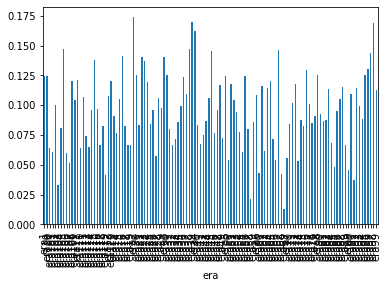

train_mean                  0.500004
train_std_dev               0.013688
train_less_than_half        0.504450
train_less_than_mean        0.504573
train_autocorrelation       0.150417
train_mean correlation      0.095063
train_Median Correlation    0.095320
train_Variance              0.001037
train_Std. Dev.             0.032201
train_sharpe                2.952130
train_smart sharpe          2.529595
train_Numerai sharpe        9.106056
dtype: float64
False
predicting per-era scores...
(501808, 314)
Neutralizing...


2020-08-31 18:50:41,001 INFO numexpr.utils: NumExpr defaulting to 2 threads.


Calculating Feature Exposure...
Drawdown...
evaluating on validation data...
predicting on validation...
getting per era scores
performance over time


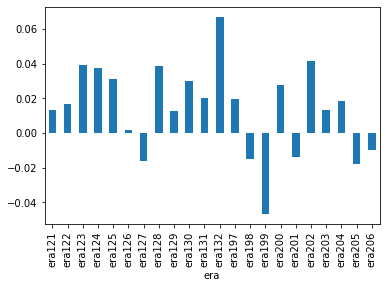

tournament_corr_example_preds    0.608426
val_mean                         0.500160
val_std_dev                      0.013713
val_less_than_half               0.502131
val_less_than_mean               0.506979
val_autocorrelation              0.100184
val_mean correlation             0.014060
val_Median Correlation           0.017579
val_Variance                     0.000645
val_Std. Dev.                    0.025396
val_sharpe                       0.553623
val_smart sharpe                 0.491432
val_Numerai sharpe               0.497158
dtype: float64
True
predicting per-era scores...
(106895, 314)
Neutralizing...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Calculating Feature Exposure...
Drawdown...

----keras_mlp_simple----
evaluating on training data...
predicting on train...
getting per era scores
performance over time


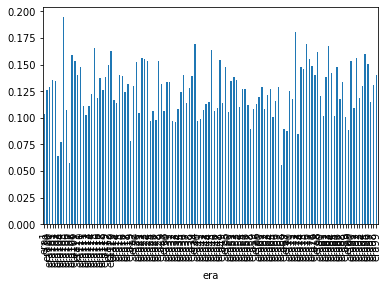

train_mean                   0.505076
train_std_dev                0.046424
train_less_than_half         0.447259
train_less_than_mean         0.517493
train_autocorrelation        0.043250
train_mean correlation       0.125611
train_Median Correlation     0.126724
train_Variance               0.000635
train_Std. Dev.              0.025201
train_sharpe                 4.984409
train_smart sharpe           4.755088
train_Numerai sharpe        15.834826
dtype: float64
False
predicting per-era scores...
(501808, 315)
Neutralizing...
Calculating Feature Exposure...
Drawdown...
evaluating on validation data...
predicting on validation...
getting per era scores
performance over time


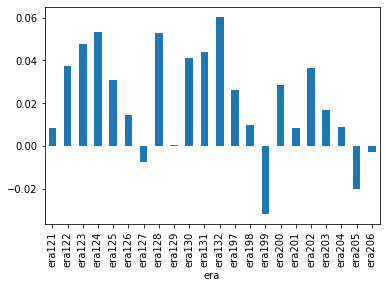

tournament_corr_example_preds    0.423611
val_mean                         0.506616
val_std_dev                      0.048278
val_less_than_half               0.440780
val_less_than_mean               0.531918
val_autocorrelation              0.193405
val_mean correlation             0.021117
val_Median Correlation           0.021535
val_Variance                     0.000584
val_Std. Dev.                    0.024174
val_sharpe                       0.873550
val_smart sharpe                 0.708146
val_Numerai sharpe               1.533605
dtype: float64
True
predicting per-era scores...
(106895, 314)
Neutralizing...
Calculating Feature Exposure...
Drawdown...
CPU times: user 6min 33s, sys: 18 s, total: 6min 51s
Wall time: 5min 22s


In [19]:
%%time
all_model_metrics = dict()
for model_name in models:
    
    print(f"\n----{model_name}----")
    model_metrics = get_all_metrics(models[model_name], feature_names, fig_name = f"{model_name}.png")
    all_model_metrics[model_name] = model_metrics
    
    gc.collect()
    

In [21]:
metric_df = pd.DataFrame.from_dict(all_model_metrics)
metric_df

,cat_reg,keras_mlp_simple
train_mean,0.500004,0.505076
train_std_dev,0.013688,0.046424
train_less_than_half,0.504450,0.447259
train_less_than_mean,0.504573,0.517493
train_autocorrelation,0.150417,0.043250
train_mean correlation,0.095063,0.125611
train_Median Correlation,0.095320,0.126724
train_Variance,0.001037,0.000635
train_Std. Dev.,0.032201,0.025201
train_sharpe,2.952130,4.984409


### Let's Compare these models aginst `example_predictions`

In [31]:
tournament_data[PREDICTION_NAME] = example_preds.values.reshape(-1, 1)

example_val_per_era_scores = get_baisc_per_era_metrics(tournament_data, isVal=True, fig_name="example_preds")
example_val_more_metrics = get_more_metrics(tournament_data, feature_names ,isVal=True)

example_preds_metrics = pd.concat([example_val_per_era_scores, example_val_more_metrics])

In [34]:
metric_df["example_preds"] = example_preds_metrics

In [35]:
metric_df

,cat_reg,keras_mlp_simple,example_preds
train_mean,0.500004,0.505076,NaN
train_std_dev,0.013688,0.046424,NaN
train_less_than_half,0.504450,0.447259,NaN
train_less_than_mean,0.504573,0.517493,NaN
train_autocorrelation,0.150417,0.043250,NaN
train_mean correlation,0.095063,0.125611,NaN
train_Median Correlation,0.095320,0.126724,NaN
train_Variance,0.001037,0.000635,NaN
train_Std. Dev.,0.032201,0.025201,NaN
train_sharpe,2.952130,4.984409,NaN


## Model for your submission

Left as an exercise to the reader 😉

▶️ Visit [An easy guide to “The hardest data science tournament on the planet”](https://towardsdatascience.com/a-guide-to-the-hardest-data-science-tournament-on-the-planet-748f46e83690) to get started with how to make your submissions directly from colab.



In [ ]:
#Train and evaluate your model for submission


## Uploading predictions using your API keys 🚀

In [ ]:
tournament_data[PREDICTION_NAME].to_csv(f"{TOURNAMENT_NAME}_{current_ds}_submission.csv")

In [ ]:
# NameOfYourAI
public_id = "YourKeys"
secret_key = "YourKeys"
model_id = "YourKeys"
napi = numerapi.NumerAPI(public_id=public_id, secret_key=secret_key)

In [ ]:
submission_id = napi.upload_predictions(f"{TOURNAMENT_NAME}_{current_ds}_submission.csv", model_id=model_id)



---


# Whats Next?
 - **Customize this according to your workflow**
 - Read about [MMC](https://docs.numer.ai/tournament/metamodel-contribution)
 - Connect on [RocketChat](https://community.numer.ai/) or [Forum](https://forum.numer.ai/)
 - Take some help from [analysis_and_tips.ipynb](https://github.com/numerai/example-scripts/blob/master/analysis_and_tips.ipynb) notebook
 - Read this topic on forum about  metrics - ["More Metrics for ya" ](https://forum.numer.ai/t/more-metrics-for-ya/636)
 - Read and try to join the [weekly Office Hours](https://docs.numer.ai/office-hours-with-arbitrage/office-hours-recaps/ohwa-1) \(I was interviewed [OHwA S02E10](https://docs.numer.ai/office-hours-with-arbitrage/office-hours-recaps-season-2/ohwa-s02e10) 😃)